In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load and prepare the data
import io
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
df.drop(['id'], axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

Saving breast-cancer.csv to breast-cancer.csv


In [3]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
# Train SVM with linear and RBF kernels
svm_linear = SVC(kernel='linear', C=1)
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')

svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

print("Linear SVM Accuracy:", svm_linear.score(X_test, y_test))
print("RBF SVM Accuracy:", svm_rbf.score(X_test, y_test))

Linear SVM Accuracy: 0.9649122807017544
RBF SVM Accuracy: 0.9736842105263158


In [6]:
#  Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.001]}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid.fit(X_scaled, y)
print("Best Parameters from Grid Search:", grid.best_params_)

Best Parameters from Grid Search: {'C': 10, 'gamma': 0.01}


In [7]:
# Cross-validation with best model
cv_score = cross_val_score(grid.best_estimator_, X_scaled, y, cv=5)
print("Cross-Validation Accuracy (mean):", round(cv_score.mean(), 4))

Cross-Validation Accuracy (mean): 0.9789


In [8]:
# Evaluation on test set
y_pred = svm_rbf.predict(X_test)
print("\nClassification Report (RBF Kernel):\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report (RBF Kernel):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[72  0]
 [ 3 39]]


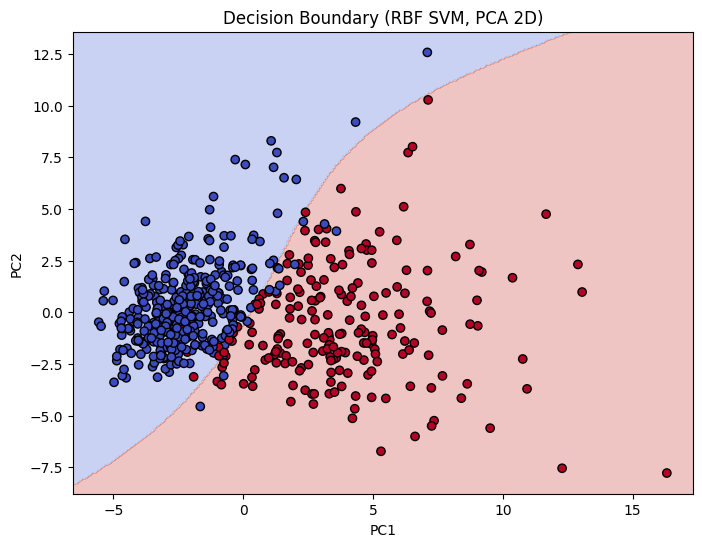

In [9]:
# Visualization using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

best_model_2d = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
best_model_2d.fit(X_pca, y)

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

plot_decision_boundary(best_model_2d, X_pca, y, "Decision Boundary (RBF SVM, PCA 2D)")